In [2]:
import sys
import sklearn
import matplotlib
import numpy as np

In [3]:
from keras.datasets import mnist
#use of keras only for dataset
(x_train,y_train),(x_test,y_test)=mnist.load_data()

print('Training Data: {}'.format(x_train.shape))
print('Training Labels: {}'.format(y_train.shape))

Using TensorFlow backend.


Training Data: (60000, 28, 28)
Training Labels: (60000,)


In [4]:
print('Testing Data: {}'.format(x_test.shape))
print('Testing Labels: {}'.format(y_test.shape))


Testing Data: (10000, 28, 28)
Testing Labels: (10000,)


In [5]:
import matplotlib.pyplot as plt

# python magic function
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


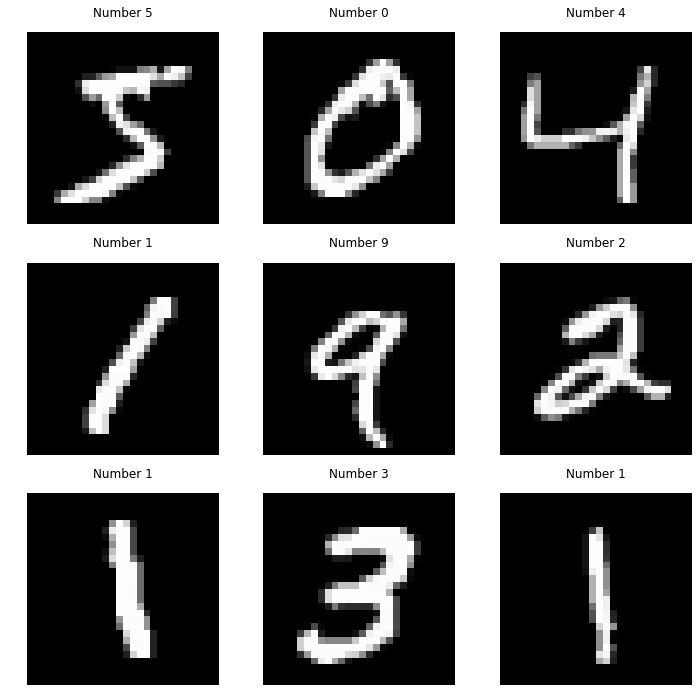

In [6]:
# create figure with 3x3 subplots using matplotlib.pyplot
fig,axs=plt.subplots(3,3,figsize=(12,12))
plt.gray()#cuz images are going to be black and white

#loop through subplots and add mnist images
for i,ax in enumerate(axs.flat):
    #flatten the axis so we can loop through with a single index
    ax.matshow(x_train[i])
    ax.axis('off')#remove tickmarks cuz they are images 
    ax.set_title('Number {}'.format(y_train[i]))
    
fig.show()    

through deep learning got 99%+ accuracy but with kmeans that much is not achievable:aim is to understand kmeans(a clustering algo) and high dimensional data
So if you want to do strictly classification on images deep learning is the way to go 

# Preprocessing the MNIST images
Images stored as NumPy arrays are 2-dimensional arrays. However, the K-means clustering algorithm provided by scikit-learn ingests 1-dimensional arrays; as a result, we will need to reshape each image.

Clustering algorithms almost always use 1-dimensional data. For example, if you were clustering a set of X, Y coordinates, each point would be passed to the clustering algorithm as a 1-dimensional array with a length of two (example: [2,4] or [-1, 4]). If you were using 3-dimensional data, the array would have a length of 3 (example: [2, 4, 1] or [-1, 4, 5]).

MNIST contains images that are 28 by 28 pixels; as a result, they will have a length of 784 once we reshape them into a 1-dimensional array.

In [7]:
#convert each image to 1D array
X=x_train.reshape(len(x_train),-1)#if -1,calculate new array length automatically
Y=y_train#already 1d array

#normalize the data to o-1 cuz value ranges from 0 to 255
X=X.astype(float)/255.

print(X.shape)
print(X[0].shape)

(60000, 784)
(784,)


#  K-Means Clustering
Due to the size of the MNIST dataset, we will use the mini-batch implementation of k-means clustering provided by scikit-learn. This will dramatically reduce the amount of time it takes to fit the algorithm to the data.

The MNIST dataset contains images of the integers 0 to 9. Thus, set the number of clusters to 10, one for each digit.

In [8]:
from sklearn.cluster import MiniBatchKMeans
#uses mini batches to solve and fit the training data much faster; imp. cuz we have 60k images
#but at the cost of accuracy
n_digits=len(np.unique(y_test))
print(n_digits)
#initialize Kmeans model
kmeans=MiniBatchKMeans(n_clusters=n_digits)

kmeans.fit(X)

10


MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

random state not set thus different results possible 

In [9]:
print(kmeans.labels_.shape)
kmeans.labels_[:20]

(60000,)


array([1, 6, 5, 9, 0, 2, 3, 8, 3, 0, 1, 9, 7, 4, 3, 0, 2, 8, 3, 0],
      dtype=int32)

here the label 4 (for first image),doesn't mean that the image was integer 4; it means that it was assigned to the 4th cluster

Also, as kmeans is unsupervised , it doesn't know what these clusters are supposed to represent,thus , we need to assign labels to each of these clusters

# Assigning Cluster Labels
K-means clustering is an unsupervised machine learning method; consequently, ***the labels assigned by our KMeans algorithm refer to the cluster each array was assigned to, not the actual target integer***.

To fix this, define  functions that will predict which integer corresponds to each cluster.

In [23]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    
    returns: dictionary of clusters assigned to each label
    this is cuz if number of clusters>number of labels,multiple clusters will be assigned to single label
    """

    inferred_labels = {}

    for i in range(kmeans.n_clusters):#loop through the clusters

        # find index of points(images) in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)
        #find all the points that have been assigned to this cluster

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])
        
        #so now for each cluster, we have list of all the points(images) that are in this cluster
        #and we have added all of the actual labels for those points to this labels list
        
        # determine most common label; assign the cluster most common label that occurs in that cluster
        #creating a bincount for all of the label values that have been assigned into each cluster
        if len(labels[0]) == 1:#if first index=1
            counts = np.bincount(labels[0])#don't need squeeze function
        else:
            counts = np.bincount(np.squeeze(labels))
        #above if/else avoida errors later when using higher no. of clusters
            
        # assign the cluster to a value in the inferred_labels dictionary
        #argmax returns int value for the maximum bincounts
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this key
            inferred_labels[np.argmax(counts)].append(i)#appends cluster label
        else:
            # create a new array in this key
            inferred_labels[np.argmax(counts)] = [i]#i as list so we can append to it
        #actual_labels:cluster#
        
        #         print(labels)
        #         print('Cluster: {}, label: {}'.format(i, np.argmax(counts)))
        
    return inferred_labels  

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array of image, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:#the cluster point was assined to is in the dictionary(the list clusters for each integer)
                predicted_labels[i] = key
                
    return predicted_labels

In [24]:
#test the infer_cluster_labels() and infer_data_labels() 
cluster_labels=infer_cluster_labels(kmeans,Y)
X_clusters=kmeans.predict(X)#predict cluster labels/ can also use kmeans.labels_ as well
predicted_labels=infer_data_labels(X_clusters,cluster_labels)

print(X_clusters,X_clusters.shape)
print(cluster_labels)
print(predicted_labels[:20])
print(Y[:20])

[1 6 5 ... 8 4 8] (60000,)
{7: [0], 3: [1, 7], 2: [2], 1: [3, 9], 6: [4], 4: [5], 0: [6], 8: [8]}
[3 0 4 1 7 2 1 8 1 7 3 1 3 6 1 7 2 8 1 7]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


# Optimizing and Evaluating the Clustering Algorithm
Since we are using this clustering algorithm for classification, accuracy is ultimately the most important metric; however, there are other metrics out there that can be applied directly to the clusters themselves, regardless of the associated labels. Two of these metrics that we will use are inertia and homogeneity.

Furthermore, earlier we made the assumption that K = 10 was the appropriate number of clusters; however, this might not be the case. Let's fit the K-means clustering algorithm with several different values of K, than evaluate the performance using our metrics.



In [25]:
from sklearn import metrics

def calculate_matrics(estimator,data,labels):
    print('Number of clusters: {}'.format(estimator.n_clusters))
    print('Inertia: {}'.format(estimator.inertia_))
    #within cluster sum of squares difference; looks at the spread of the clusters in the high dimesnional space we are working in
    #tightly grouped clusters:low inertia
    #vice versa for widely spaced clusters
    #goes down as the number of cluster increases and also depends on the number of datapoints
    
    print('Homogeneity: {}'.format(metrics.homogeneity_score(labels,estimator.labels_)))#actual class labels, estiamtor labels
    # a clustering result satisfies homogeneity if all the clusters contain only those data points which are members of a single class(same labels) 
    

# Accuracy on training dataset

In [30]:
clusters=[10,16,36,64,144,256,400]#good even number(sqaures of 4,6,8,12,16 and 10 being the minimum number of clusters)

#test for different numbers of clusters
for n_clusters in clusters:
    estimator=MiniBatchKMeans(n_clusters=n_clusters)
    estimator.fit(X)
    
    calculate_matrics(estimator,X,Y)
    
    #determine predicted labels
    cluster_labels=infer_cluster_labels(estimator,Y)
    predicted_Y=infer_data_labels(estimator.labels_,cluster_labels)#here i used kmeans.labels_ than kmeans.predict(X)
    
    print('Accuracy: {}\n'.format(metrics.accuracy_score(Y,predicted_Y)))

Number of clusters: 10
Inertia: 2389282.5376547435
Homogeneity: 0.44810906278308577
Accuracy: 0.52095

Number of clusters: 16
Inertia: 2204631.869813872
Homogeneity: 0.5682534854165137
Accuracy: 0.6692666666666667

Number of clusters: 36
Inertia: 1976296.851215268
Homogeneity: 0.668778774155368
Accuracy: 0.7342166666666666

Number of clusters: 64
Inertia: 1822661.3534384826
Homogeneity: 0.7318628892517384
Accuracy: 0.8039

Number of clusters: 144
Inertia: 1635226.8812118405
Homogeneity: 0.8036050098123823
Accuracy: 0.8663833333333333

Number of clusters: 256
Inertia: 1512363.485018906
Homogeneity: 0.8384416983440075
Accuracy: 0.89395



/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:1559: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:1559: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:1559: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Number of clusters: 400
Inertia: 1432057.0670305884
Homogeneity: 0.861597361026549
Accuracy: 0.9095166666666666



small number of clusters=> faster calculations
inertia=0 => sum of squares difference=0 => number of clusters= number of data points,ie, only one data point in each cluster

Also for 400 clusters,accuracy actually increased  slightly and it took substantially larger time than 256,So 256 is some what nice tradeoff

**The above accuracies vary each time it's run cuz we are randomly intializing where the centroid is starting as no random state seed was set; SO INITIALIZATION IS IMP. FOR KMEANS CLUSTERING**

In [31]:
# test kmeans algorithm on testing dataset
# convert each image to 1 dimensional array
X_test=x_test.reshape(len(x_test),-1)

#normalize the data to 0 - 1
X_test=X_test.astype(float)/255.

# initialize and fit KMeans algorithm on training data
kmeans=MiniBatchKMeans(n_clusters=256)
kmeans.fit(X)#retraining so we can generate cluster_labels dictionary again
cluster_labels=infer_cluster_labels(kmeans,Y)

#predict labels for testing data
test_clusters=kmeans.predict(X_test)#predict which cluster each test image belongs to
predicted_labels=infer_data_labels(kmeans.predict(X_test),cluster_labels)

# calculate and print accuracy
print('Accuracy: {}\n'.format(metrics.accuracy_score(y_test, predicted_labels)))

Accuracy: 0.899



**So we are equall accurate on testing as well as training data => generalizing(no overfitting) very well given we have 10k test images**

# hey, we had only 10 digits, so 10 cluster should work?? why 256 works very well??
**ANS**: There are multiple ways to write number 2 and to the computer those are going to be drastically different images and as a result they fit better in different clusters than in the same cluster. to understand visualize:

# Visualizing Cluster Centroids
The most representative point within each cluster is called the centroid. If we were dealing with X,Y points, the centroid would simply be a point on the graph. However, since we are using arrays of length 784, our centroid is also going to be an array of length 784(we are gonna be high dimensional in that space). We can reshape this array back into a 28 by 28 pixel image and plot it.

These graphs will display the most representative image for each cluster.

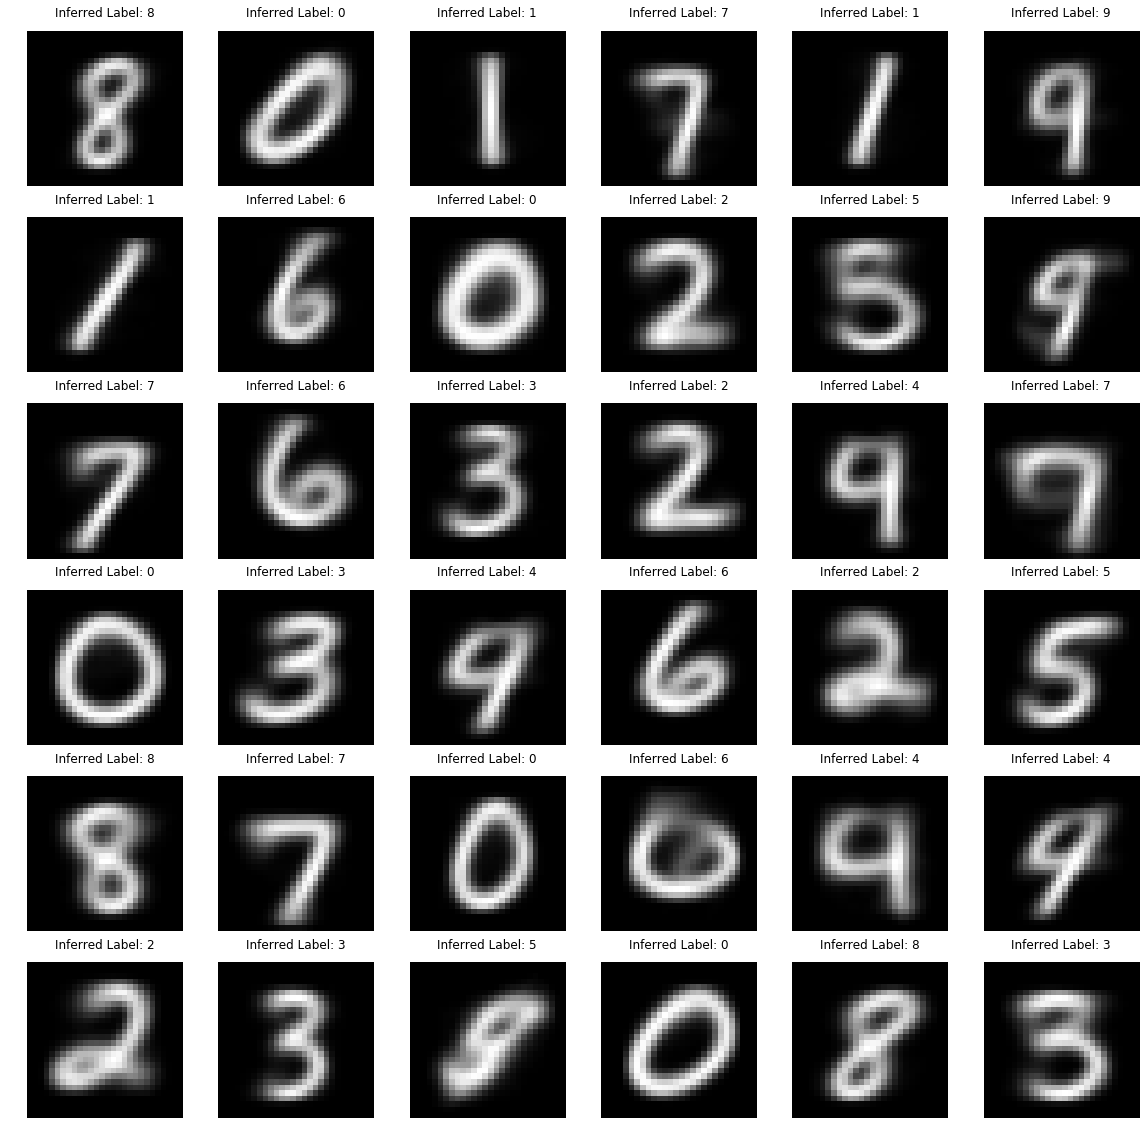

In [32]:
# Initialize and fit KMeans algorithm
kmeans = MiniBatchKMeans(n_clusters = 36)
kmeans.fit(X)

# record centroid values
centroids = kmeans.cluster_centers_ #algo picks a centroid and assign all of the points close to it to that particluar cluster
#then, recalcualte the centroid and iterate over that process again and again, till the values are not changing anymore

# reshape centroids into images
images = centroids.reshape(36, 28, 28)#length=36 as we use 36 clusters(thus 36 centroids) for easy plotting
#not much concerned about accuracy here just visualzing the centroids
images *= 255
images = images.astype(np.uint8)

# determine cluster labels
cluster_labels = infer_cluster_labels(kmeans, Y)

# create figure with subplots using matplotlib.pyplot
fig, axs = plt.subplots(6, 6, figsize = (20, 20))
plt.gray()

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):
    
    # determine inferred label using cluster_labels dictionary
    for key, value in cluster_labels.items():
        if i in value:
            ax.set_title('Inferred Label: {}'.format(key))
    
    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')
    

still there are some misclassifications(due to blurriness)

In deep neural n/w's, you can't visualize as above so that's why we used kmeans